In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gamspec import *

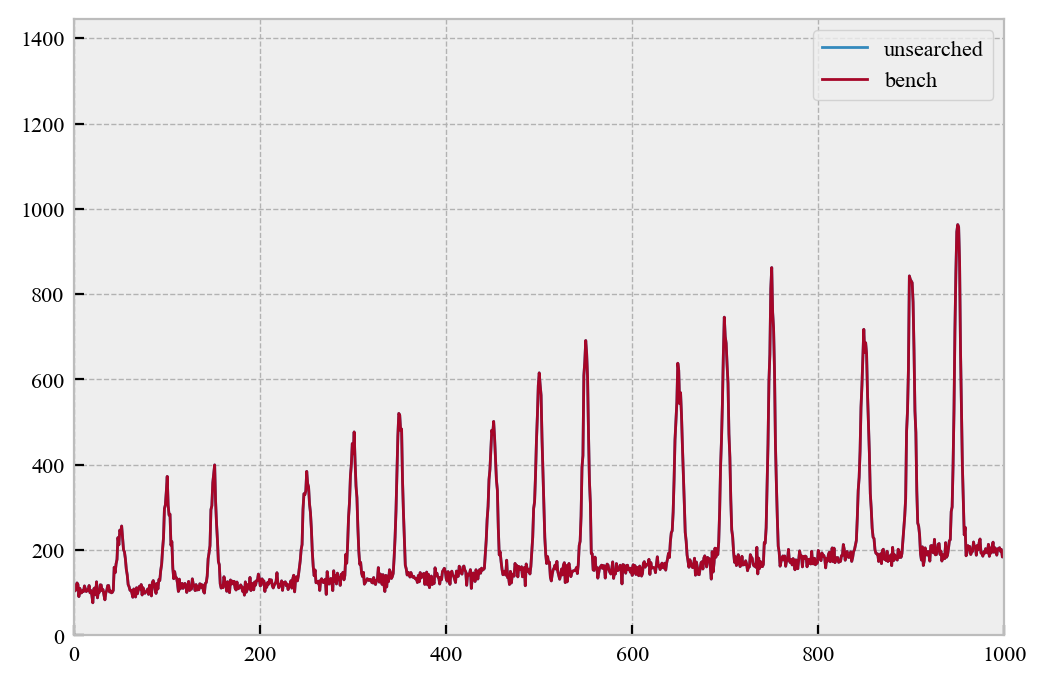

In [28]:
unsearched = SimulatedSpectrum(length=1000, base_intensity=100, base_function=lambda x: x, base_amplitude=100,
                           peaks_info=[[50, 4.0, 1500], [100, 3.5, 2000], [150, 3.0, 2000],
                                       [250, 4.0, 2500], [300, 3.7,3000], [350, 3.0, 3000],
                                       [450, 4.0, 3500], [500, 3.5, 4000], [550, 3.0, 4000],
                                       [650, 4.0, 4500], [700, 3.5, 5000], [750, 3.0, 5000],
                                       [850, 4.0, 5500], [900, 3.5, 6000], [950, 3.0, 6000]], label="unsearched")
reference = SimulatedSpectrum(length=1000, base_intensity=100, base_function=lambda x: x, base_amplitude=100,
                             peaks_info=[[50, 4.0, 1500], [100, 3.5, 2000], [150, 3.0, 2000],
                                       [250, 4.0, 2500], [300, 3.7,3000], [350, 3.0, 3000],
                                       [450, 4.0, 3500], [500, 3.5, 4000], [550, 3.0, 4000],
                                       [650, 4.0, 4500], [700, 3.5, 5000], [750, 3.0, 5000],
                                       [850, 4.0, 5500], [900, 3.5, 6000], [950, 3.0, 6000]], label="bench")
unsearched.plot()
unsearched.regions = []
reference.plot()
plt.legend()

26


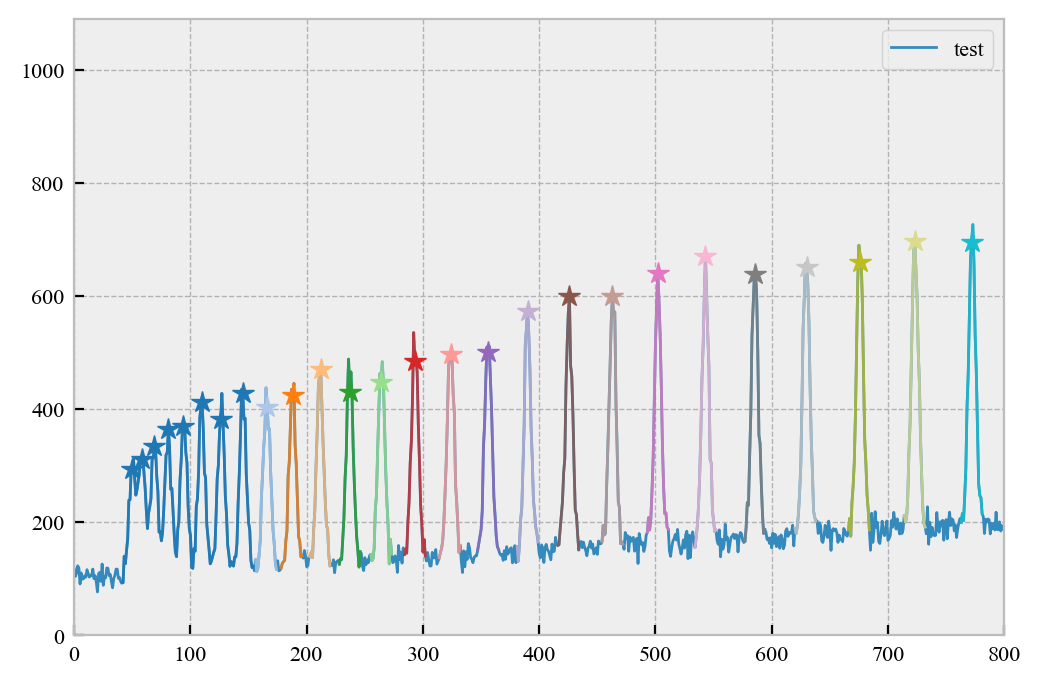

In [40]:
data = []
ind = 50
for i in range(5, 40):
    data.append([ind, 3, 1000+i*100])
    ind += i*1.7
    if ind > 800:
        print(i-5+1)
        break
unsearched = SimulatedSpectrum(length=800, base_intensity=100, base_function=lambda x: x, base_amplitude=100,
                         peaks_info=data, label="test")
reference = SimulatedSpectrum(length=800, base_intensity=100, base_function=lambda x: x, base_amplitude=100,
                         peaks_info=data, label="test")
unsearched = SavitzkySmoother(2, 5)(unsearched)
unsearched.regions = []
reference.regions = PeakSearcher._merge(reference.regions)

reference.plot()
reference.plot_regions()
plt.legend()

In [30]:
searchers = [
    GaussPeakSearcher(2, threshold=0.1),
    GaussPeakSearcher(3, threshold=0.1),

    DifferentialPeakSearcher(poly_order=2, hwidth=4, derive_order=1, zero_width=5),
    DifferentialPeakSearcher(poly_order=2, hwidth=4, derive_order=1, zero_width=7),
    DifferentialPeakSearcher(poly_order=2, hwidth=4, derive_order=2, zero_width=5),
    DifferentialPeakSearcher(poly_order=2, hwidth=4, derive_order=2, zero_width=8),
    
    CovarianceSearcher(hwidth=3, FWHM=6, mode='inverse'),
    CovarianceSearcher(hwidth=3, FWHM=6, mode='uniform'),

    SymmetricZeroAreaConvolutionSearcher(hwidth=3, FWHM=6, func='gaussian'),
    
    SecondConvolutionPeakSearcher(hwdith=20, baseline=True)
]


In [31]:
class PeakSearcherEvaluator:
    
    def __init__(self):
        self.average_area_calculator = AverageAreaCalculator(10)
        self.fit_area_calculator = RegionPeakFitter()

    def evaluate(self, searched, unsearched, reference):

        
        val ={
            
            'correct_peaks': self.establish_peak_correspondance(searched, reference),
            'total_peaks': len(searched.peaks),
            'correct_peaks_ratio': self.establish_peak_correspondance(searched, reference) / len(searched.peaks),
            'total_peak_ratio': self.establish_peak_correspondance(searched, reference) / len(reference.peaks),
            'factor': self.factor(searched, reference),
        }
        return val

    def factor(self, searched, reference):
        data1 = [[peak['location'], 2, 1] for peak in searched.peaks]
        data2 = [[peak['location'], 2, 1] for peak in reference.peaks]
        spe1 = SimulatedSpectrum(length=len(searched), peaks_info=data1, base_noised=False)
        spe2 = SimulatedSpectrum(length=len(searched), peaks_info=data2, base_noised=False)
        return np.dot(spe1, spe2) / np.linalg.norm(spe1) / np.linalg.norm(spe2)

    def establish_peak_correspondance(self, searched, reference):
        
        peaks_index_searched = []
        peaks_index_reference = []
        for i, ipeak in enumerate(reference.peaks):
            for j, jpeak in enumerate(searched.peaks):
                if abs(jpeak['location'] - ipeak['center']) <= 2:
                    peaks_index_searched.append(j)
                    peaks_index_reference.append(i)
        self.peaks_index_searched = peaks_index_searched
        self.peaks_index_reference = peaks_index_reference
        return len(peaks_index_searched)                   

    # def compare_peak_boundary(self, searched, reference):
    #     for i, j in zip(self.peaks_index_searched, self.peaks_index_reference):

            

eva = PeakSearcherEvaluator()

In [32]:
results = []
searcheds = []
for searcher in searchers:
    searched = searcher(unsearched)
    val = {'name': searcher.label}
    val.update(eva.evaluate(searched, unsearched, reference))
    results.append(val)
    searcheds.append(searched)
results = pd.DataFrame(results)
results

,name,correct_peaks,total_peaks,correct_peaks_ratio,total_peak_ratio,factor
0,GaussPeakSearcher[O2],27,32,0.843750,1.000000,0.890471
1,GaussPeakSearcher[O3],26,31,0.838710,0.962963,0.842577
2,DifferentialPeakSearcher[O1],23,24,0.958333,0.851852,0.931713
3,DifferentialPeakSearcher[O1],20,21,0.952381,0.740741,0.871981
4,DifferentialPeakSearcher[O2],26,26,1.000000,0.962963,0.976766
5,DifferentialPeakSearcher[O2],23,23,1.000000,0.851852,0.920553
6,CovarianceSearcher[F6],25,25,1.000000,0.925926,0.946108
7,CovarianceSearcher[F6],25,25,1.000000,0.925926,0.959890
8,SZACSearcher[F6],26,39,0.666667,0.962963,0.799676
9,SecondConvolutionSearcher[F20],24,25,0.960000,0.888889,0.934462


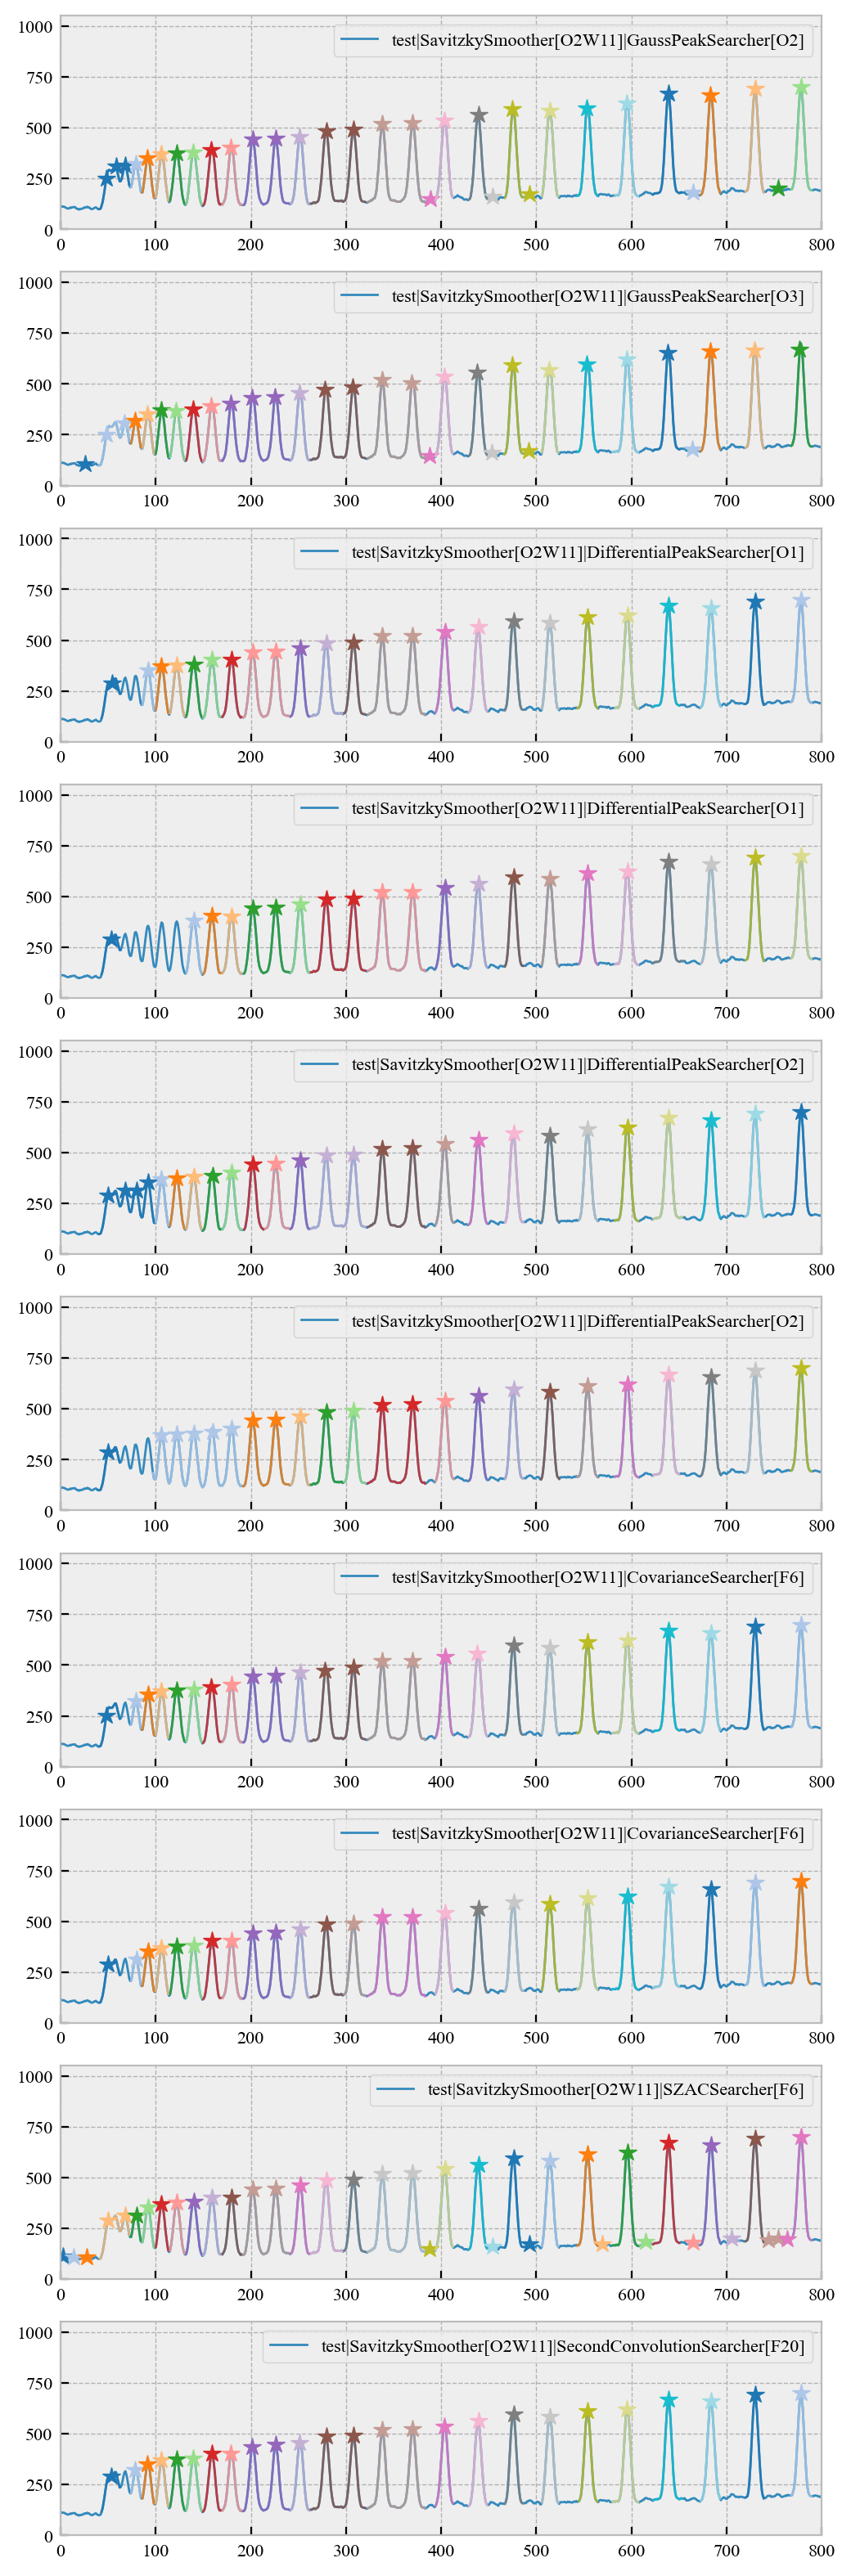

In [33]:
fig, axes = plt.subplots(len(searcheds), 1, figsize=(6, 2*len(searcheds)))
for i, searched in enumerate(searcheds):
    searched.plot(axes=axes[i])
    searched.plot_regions(axes=axes[i])
    axes[i].legend()